In [1]:
#Imports 
import torch
import copy
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
#Checking Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
#Dataset Class Definition
class FinSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [4]:
#Loading Tokeniser
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [5]:
#Loading Validation Splits
X_tw_val = pd.read_csv("data/splits/twitter_val_text.csv").squeeze()
y_tw_val = pd.read_csv("data/splits/twitter_val_labels.csv").squeeze()

X_news_val = pd.read_csv("data/splits/news_val_text.csv").squeeze()
y_news_val = pd.read_csv("data/splits/news_val_labels.csv").squeeze()

X_reports_val = pd.read_csv("data/splits/reports_val_text.csv").squeeze()
y_reports_val = pd.read_csv("data/splits/reports_val_labels.csv").squeeze()

print("Validation splits loaded")

Validation splits loaded


In [6]:
#DataLoaders
tw_val_loader = DataLoader(
    FinSentimentDataset(X_tw_val, y_tw_val, tokenizer),
    batch_size=16,
    shuffle=False
)

news_val_loader = DataLoader(
    FinSentimentDataset(X_news_val, y_news_val, tokenizer),
    batch_size=16,
    shuffle=False
)

reports_val_loader = DataLoader(
    FinSentimentDataset(X_reports_val, y_reports_val, tokenizer),
    batch_size=16,
    shuffle=False
)

print("Validation DataLoaders ready")

Validation DataLoaders ready


In [7]:
#Loading Full Processed Dataset
twitter = pd.read_csv("data/processed/twitter.csv")
news = pd.read_csv("data/processed/news.csv")
reports = pd.read_csv("data/processed/reports.csv")

print("Training data loaded")

Training data loaded


In [8]:
#Recreating Train Loaders
from sklearn.model_selection import train_test_split

#Function
def create_train_loader(df):
    X = df["text"]
    y = df["label"]

    X_train, _, y_train, _ = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    dataset = FinSentimentDataset(X_train, y_train, tokenizer)
    return DataLoader(dataset, batch_size=16, shuffle=True), len(dataset)

#For each Client
tw_train_loader, tw_size = create_train_loader(twitter)
news_train_loader, news_size = create_train_loader(news)
reports_train_loader, reports_size = create_train_loader(reports)

print("Train loaders created")

Train loaders created


In [9]:
#Recreating Local Training Function
def local_train(model, train_loader, epochs=3):
    model.train()
    optimizer = AdamW(model.parameters(), lr=2e-5)

    for _ in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )

            outputs.loss.backward()
            optimizer.step()

    return model

In [10]:
#Recreating FedAvg Logic
def fedavg(global_model, client_models, client_sizes):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = sum(
            client_sizes[i] * client_models[i].state_dict()[key]
            for i in range(len(client_models))
        ) / sum(client_sizes)

    global_model.load_state_dict(global_dict)
    return global_model

In [11]:
#Defining Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].numpy())

    acc = accuracy_score(all_labels, all_preds)
    _, _, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    return acc, f1

In [12]:
#Initialising Global Model
global_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3
).to(device)

print("Global model initialized")

Global model initialized


In [13]:
#FedAvg Loop Rounds = 5, local epochs = 3
ROUNDS = 5
LOCAL_EPOCHS = 3

results = []

for r in range(ROUNDS):
    print(f"\n===== Federated Round {r+1}/{ROUNDS} =====")

    tw_model = copy.deepcopy(global_model)
    news_model = copy.deepcopy(global_model)
    reports_model = copy.deepcopy(global_model)

    tw_model = local_train(tw_model, tw_train_loader, LOCAL_EPOCHS)
    news_model = local_train(news_model, news_train_loader, LOCAL_EPOCHS)
    reports_model = local_train(reports_model, reports_train_loader, LOCAL_EPOCHS)

    global_model = fedavg(
        global_model,
        [tw_model, news_model, reports_model],
        [tw_size, news_size, reports_size]
    )

    acc_t, f1_t = evaluate_model(global_model, tw_val_loader)
    acc_n, f1_n = evaluate_model(global_model, news_val_loader)
    acc_r, f1_r = evaluate_model(global_model, reports_val_loader)

    results.append([r+1, f1_t, f1_n, f1_r])

    print(f"Twitter F1: {f1_t:.4f} | News F1: {f1_n:.4f} | Reports F1: {f1_r:.4f}")


===== Federated Round 1/5 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.6485 | News F1: 0.4583 | Reports F1: 0.5714

===== Federated Round 2/5 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.7612 | News F1: 0.8436 | Reports F1: 0.7795

===== Federated Round 3/5 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.7883 | News F1: 0.8433 | Reports F1: 0.7930

===== Federated Round 4/5 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.7977 | News F1: 0.8455 | Reports F1: 0.7909

===== Federated Round 5/5 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.7998 | News F1: 0.9102 | Reports F1: 0.8301


In [14]:
#Results
results_df = pd.DataFrame(
    results,
    columns=["Round", "Twitter_F1", "News_F1", "Reports_F1"]
)

results_df["Avg_F1"] = results_df[["Twitter_F1", "News_F1", "Reports_F1"]].mean(axis=1)
results_df

,Round,Twitter_F1,News_F1,Reports_F1,Avg_F1
0,1,0.648463,0.458302,0.571372,0.559379
1,2,0.761231,0.843637,0.779483,0.794784
2,3,0.788262,0.843272,0.792955,0.808163
3,4,0.797742,0.845487,0.790925,0.811385
4,5,0.799809,0.910209,0.830079,0.846699


In [15]:
#Saving Global Model Trained for 5 Rounds
import os

os.makedirs("models/global_fedavg_R5", exist_ok=True)
global_model.save_pretrained("models/global_fedavg_R5")
tokenizer.save_pretrained("models/global_fedavg_R5")

results_df.to_csv("models/global_fedavg_R5/results.csv", index=False)

print("Final global FedAvg model saved")

Final global FedAvg model saved


In [17]:
#Saving Results
import os
os.makedirs("results", exist_ok=True)

results_df.to_csv("results/fedavg_multiround_results.csv", index=False)

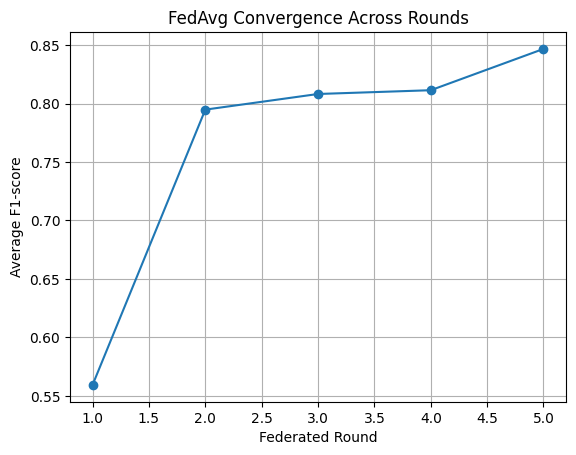

In [18]:
#Result Plot 
import matplotlib.pyplot as plt

plt.plot(results_df["Round"], results_df["Avg_F1"], marker="o")
plt.xlabel("Federated Round")
plt.ylabel("Average F1-score")
plt.title("FedAvg Convergence Across Rounds")
plt.grid(True)
plt.show()

In [19]:
"""
Interpretation -
Multi-round FedAvg significantly outperforms single-round aggregation
Performance stabilizes after ~4–5 rounds
Domain-specific clients benefit unequally due to data heterogeneity
"""

'\nInterpretation -\nMulti-round FedAvg significantly outperforms single-round aggregation\nPerformance stabilizes after ~4–5 rounds\nDomain-specific clients benefit unequally due to data heterogeneity\n'

In [20]:
# FedAvg Loop — Rounds = 10, local epochs = 3
ROUNDS = 10
LOCAL_EPOCHS = 3

results_10 = []

for r in range(ROUNDS):
    print(f"\n===== Federated Round {r+1}/{ROUNDS} =====")

    # Clone global model to clients
    tw_model = copy.deepcopy(global_model)
    news_model = copy.deepcopy(global_model)
    reports_model = copy.deepcopy(global_model)

    # Local training on each client
    tw_model = local_train(tw_model, tw_train_loader, LOCAL_EPOCHS)
    news_model = local_train(news_model, news_train_loader, LOCAL_EPOCHS)
    reports_model = local_train(reports_model, reports_train_loader, LOCAL_EPOCHS)

    # FedAvg aggregation
    global_model = fedavg(
        global_model,
        [tw_model, news_model, reports_model],
        [tw_size, news_size, reports_size]
    )

    # Global evaluation on each client validation set
    acc_t, f1_t = evaluate_model(global_model, tw_val_loader)
    acc_n, f1_n = evaluate_model(global_model, news_val_loader)
    acc_r, f1_r = evaluate_model(global_model, reports_val_loader)

    results_10.append([r+1, f1_t, f1_n, f1_r])

    print(f"Twitter F1: {f1_t:.4f} | News F1: {f1_n:.4f} | Reports F1: {f1_r:.4f}")


===== Federated Round 1/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8018 | News F1: 0.8805 | Reports F1: 0.8092

===== Federated Round 2/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8048 | News F1: 0.8874 | Reports F1: 0.8049

===== Federated Round 3/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8106 | News F1: 0.9021 | Reports F1: 0.8258

===== Federated Round 4/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8101 | News F1: 0.8982 | Reports F1: 0.8133

===== Federated Round 5/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8003 | News F1: 0.9154 | Reports F1: 0.8304

===== Federated Round 6/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8196 | News F1: 0.8926 | Reports F1: 0.8183

===== Federated Round 7/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8210 | News F1: 0.9008 | Reports F1: 0.8265

===== Federated Round 8/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8165 | News F1: 0.9019 | Reports F1: 0.8246

===== Federated Round 9/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8207 | News F1: 0.9019 | Reports F1: 0.8177

===== Federated Round 10/10 =====


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Twitter F1: 0.8168 | News F1: 0.9072 | Reports F1: 0.8150


In [21]:
#Results
import pandas as pd

results_10_df = pd.DataFrame(
    results_10,
    columns=["Round", "Twitter_F1", "News_F1", "Reports_F1"]
)

results_10_df["Avg_F1"] = results_10_df[
    ["Twitter_F1", "News_F1", "Reports_F1"]
].mean(axis=1)

results_10_df

,Round,Twitter_F1,News_F1,Reports_F1,Avg_F1
0,1,0.801782,0.880463,0.809216,0.830487
1,2,0.804818,0.887450,0.804869,0.832379
2,3,0.810562,0.902129,0.825799,0.846163
3,4,0.810111,0.898201,0.813274,0.840529
4,5,0.800284,0.915396,0.830401,0.848694
5,6,0.819634,0.892642,0.818280,0.843519
6,7,0.820972,0.900798,0.826496,0.849422
7,8,0.816474,0.901905,0.824579,0.847652
8,9,0.820675,0.901881,0.817659,0.846738
9,10,0.816791,0.907160,0.814984,0.846312


In [22]:
#Saving 10 rounds Model
import os

os.makedirs("models/global_fedavg_R10", exist_ok=True)

global_model.save_pretrained("models/global_fedavg_R10")
tokenizer.save_pretrained("models/global_fedavg_R10")

print("Final global FedAvg (10 rounds) model saved")

Final global FedAvg (10 rounds) model saved


In [23]:
#Saving Results
import os

os.makedirs("results", exist_ok=True)
results_10_df.to_csv("results/fedavg_10_rounds.csv", index=False)

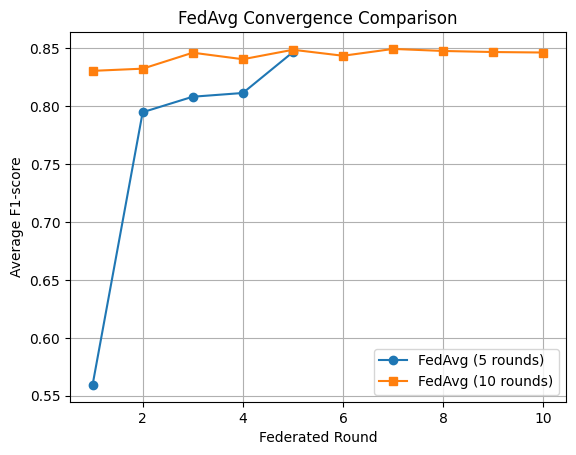

In [24]:
#Result Plot 5 v 10
import matplotlib.pyplot as plt

plt.plot(results_df["Round"], results_df["Avg_F1"],
         marker="o", label="FedAvg (5 rounds)")

plt.plot(results_10_df["Round"], results_10_df["Avg_F1"],
         marker="s", label="FedAvg (10 rounds)")

plt.xlabel("Federated Round")
plt.ylabel("Average F1-score")
plt.title("FedAvg Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()